<a id="topV"></a>

# Viewing COS Data

# Learning Goals
### This Notebook is designed to walk the user (*you*) through:
#### 1. **[Downloading](#downloadV) Existing Cosmic Origins Spectrograph (*COS*) data from the online archive**
#### 2. **[Reading in the data](#readInV) using `Python`**
#### 3. **[Displaying the data](#plottingV) using common plotting techniques**

# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to begin analyzing COS data of your choice by walking you through downloading, reading, and viewing a spectrum obtained with COS.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will import the following packages:

- numpy to handle array functions
- astropy.io fits for accessing FITS files
- astropy.table Table for creating tidy tables of the data
- astropy.units and astropy.visualization.quantity_support for dealing with units
- matplotlib.pyplot for plotting data
- astroquery.mast Mast and Observations for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive

In [1]:
#Make matplotlib look good in a notebook
%matplotlib inline
# Manipulating arrays
import numpy as np
# Reading in data
from astropy.io import fits
from astropy.table import Table
# Dealing with units and plotting them
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
# Plotting
import matplotlib.pyplot as plt
# Downloading data from archive
from astroquery.mast import Mast
from astroquery.mast import Observations
from astroquery.mast import Catalogs


## We will also define a few directories in which to place our data and plots, as well as a few colors we will use in plots later.

In [2]:
# These will be important directories for the notebook
cwd = !pwd
cwd = cwd[0]

datadir = cwd + '/data/'
outputsdir = cwd + '/output/'
plotsdir = cwd + '/output/plots/'

# A few colors for plotting - feel free to change these!
segment_colors = {'NUVA':'#1813CE','NUVB':'#61946E','NUVC':'#8C1A11'}

<a id="downloadV"></a>
# 1. Downloading the Data

One can search for COS data from both a browser-based gui and a command-line `Python` library.

##### *A more in-depth MAST archive tutorial can be found [here](https://mast.stsci.edu/api/v0/MastApiTutorial.html).*


## 1.1 The MAST Web Search
A browser gui for searching HST archival data can be found [here](http://archive.stsci.edu/hst/search.php).

The search page is laid out as in fig. 1.1:
### Fig 1.1
<center><img src=figures/Mast_hst_searchform3.png width ="900" title="MAST Archive search form for a COS data query"> </center>

where here we have indicated we would like to find all archival data from the **COS near-ultraviolet configuration science** data, taken with the **G230L grating** while looking at **stars**. The output columns we have selected to see are visible in the bottom left of Fig 1.1.

Note that if you have a list of coordinates, Observation ID(s), etc. you can click on the "File Upload Form" and attach your list of OBSIDs or identifying features. Then specify which type of data your list contains using the "File Contents" drop-down menu.

Figure 1.2 shows the *long* results of our search.
### Fig 1.2
<center><img src=figures/mast_hst_searchRes.png width ="900" title="MAST Archive search results for a COS data query"> </center>


#### We now choose our dataset.
We *arbitrarily* select LBBD01020, taken under an calibration program described as:
> "NUV Spectroscopic Sensitivity Monitoring"

This is a white dwarf star  known as [WD1057+719](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=WD1057%2B719&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id)

Clicking on the dataset, we are taken to a page displaying a preview spectrum (Fig 1.3).
### Fig 1.3

<center><img src=./figures/preview_spec1.png width ="900" title="MAST Archive preview spectrum of LBBD01020"> </center>

We now return to the [search page](http://archive.stsci.edu/hst/search.php) and enter in LBBD01020 under "Dataset" with no other parameters set. Hitting search, now we see a single-rowed table with just our dataset, and *crucially* the option to download datasets. We mark the row we wish to download and click "Submit marked data for retrieval from STDADS". See Fig 1.4.

### Fig. 1.4

<center><img src=figures/LBBD01020_res.png width ="900" title="MAST Archive dataset overview of LBBD01020"> </center>

Now we see a page like in Fig 1.5, where we can either sign in with STScI credentials, or simply provide our email to proceed (relatively) anonymously. Make sure to select "Deliver the data to the Archive staging area". Hit "Send Retrieval Request to STDADS" and you will recieve an email with instructions on downloading with ftp. You will need to do this step from the command line.

In the case of this request, the command to retrieve the data was:
>`wget -r --ftp-user=anonymous --ask-password ftps://archive.stsci.edu/stage/anonymous/anonymous42822 --directory-prefix=datadir`

where the password was the email address used, and datadir is the directory defined at the beginning of this notebook.. Now all the data is in a subdirectory `"/archive.stsci.edu/stage/anonymous/anonymous42822/"`

#### Well Done!


### Exercise 1: *Searching the archive for TRAPPIST-1 data*

[TRAPPIST-1](https://en.wikipedia.org/wiki/TRAPPIST-1) is a cool red dwarf with a multiple-exoplanet system. 
- Find its coordinates using the [SIMBAD Basic Search](http://simbad.u-strasbg.fr/simbad/sim-fbasic).
- Use those coordinates in the [MAST web search](https://archive.stsci.edu/hst/search.php) to find all COS exposures of the system.
- Limit the search terms to find the COS dataset taken in the COS far-UV configuration with the grating G130M.

#### What is the dataset ID, and how long was the exposure?

Place your answer in the cell below.

In [3]:
# Your answer here



## 1.2 astroquery.mast
Another way to search for and download archived datasets is within `Python` using the module [`astroquery.mast`](https://astroquery.readthedocs.io/en/latest/mast/mast.html). We have already imported 2 of this module's key tools: `Observations` and `Mast`.

There are *many* options for searching the archive with astroquery, but we will begin with a very general search using the coordinates we found in the last section to find the same dataset. 
- Our coordinates were:      (11:00:34.126 +71:38:02.80). 
    - We can search these coordinates as sexagesimal coordinates, or convert them to decimal degrees.

In [4]:
query_1 = Observations.query_object("11:00:34.126 +71:38:02.80", radius="5 sec")

This command has generated a table of objects called **"query_1"**. We can see what information we have on the objects in the table by printing its *`keys`*, and see how many objects are in the table with `len(query_1)`.

In [5]:
print(f"We have table information on {len(query_1)} observations in the following categories/columns:\n")
(query_1.keys())

We have table information on 708 observations in the following categories/columns:



['intentType',
 'obs_collection',
 'provenance_name',
 'instrument_name',
 'project',
 'filters',
 'wavelength_region',
 'target_name',
 'target_classification',
 'obs_id',
 's_ra',
 's_dec',
 'dataproduct_type',
 'proposal_pi',
 'calib_level',
 't_min',
 't_max',
 't_exptime',
 'em_min',
 'em_max',
 'obs_title',
 't_obs_release',
 'proposal_id',
 'proposal_type',
 'sequence_number',
 's_region',
 'jpegURL',
 'dataURL',
 'dataRights',
 'mtFlag',
 'srcDen',
 'obsid',
 'distance']

#### Now we narrow down a bit with some additional parameters (wavelength_region,instrument_name and configuration, dataproduct_type):

In [6]:
query_2 = Observations.query_criteria(s_ra=[165., 166.], s_dec=[+71.,+72.],
                                        wavelength_region="UV", instrument_name="COS/NUV", 
                                        dataproduct_type = "spectrum")
query_2[:5] #NOT THE FULL TABLE!

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str8,int64,str3,str9,str10,float64,float64,float64,float64,float64,str2,str5,float64,float64,str7,str50,float64,str7,str19,str5,str7,str3,int64,str6,str47,str37,str38,str6,bool,float64,str7,str10,str10
spectrum,3,HST,le0sl2020,WD1057+719,165.1417487528,71.63404952112,59062.99029997,59063.00013793,850.208,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59064.04225,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174867 71.63404945 0.00069444,mast:HST/product/le0sl2020_x1dsum.png,mast:HST/product/le0sl2020_x1dsum.fits,PUBLIC,False,nan,science,2008158631,2048961109
spectrum,3,HST,le0sl2010,WD1057+719,165.1417487537,71.63404952125,59062.98133032,59062.98758032,540.0,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59063.2483,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174868 71.63404945 0.00069444,mast:HST/product/le0sl2010_x1dsum.png,mast:HST/product/le0sl2010_x1dsum.fits,PUBLIC,False,nan,science,2008158537,2048960143
spectrum,1,HST,le0sl2h7q,WD1057+719,165.1417487541,71.6340495213,59062.97992515,59062.97993325,0.7,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59063.24816,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174868 71.63404945 0.00069444,--,mast:HST/product/le0sl2h7q_rawacq.fits,PUBLIC,False,nan,science,2008158485,2048960082
spectrum,1,HST,le0sl2h6q,WD1057+719,165.1417487542,71.63404952132,59062.97652998,59062.97742115,77.0,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59063.24814,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174868 71.63404945 0.00069444,--,mast:HST/product/le0sl2h6q_rawacq.fits,PUBLIC,False,nan,science,2008158489,2048960085
spectrum,1,HST,le0sl2h5q,WD1057+719,165.1417487549,71.63404952141,59062.96944807,59062.97560547,532.0,UV,G230L,170.0,320.0,STAR;DA,Cycle 27 COS NUV Spectroscopic Sensitivity Monitor,59063.2481,COS/NUV,"Fischer, William J.",15778,CAL/COS,HST,--,CALCOS,CIRCLE ICRS 165.14174868 71.63404945 0.00069444,--,mast:HST/product/le0sl2h5q_rawacq.fits,PUBLIC,False,nan,science,2008158486,2048960083


#### Caution! 
<img src=figures/warning.png width ="60" title="MAST Archive preview spectrum of LBBD01020"> 
Please note that these queries are Astropy tables and do not always respond as expected for other data structures like Pandas DataFrames. For instance, the first way of filtering a table shown below is correct, but the second will consistently produce the *wrong result*.

In [7]:
# Searching a table generated with a query
## First correct way using masking
mask = (query_1['obs_id'] == 'lbbd01020') # NOTE, obs_id must be lower-case
print("Correct way yields: \n" , query_1[mask]['obs_id'],"\n\n")

# Second incorrect way
print("Incorrect way yields: \n" , query_1['obs_id' == 'LBBD01020']['obs_id'])

Correct way yields: 
   obs_id 
---------
lbbd01020 


Incorrect way yields: 
 tess-s0014-4-3


### Now we can choose download our data products from the archive dataset.

We will first generate a list of data products in the dataset: `product_list`. Then we will download *just the* **minimum recommended products**, which are the fully calibrated spectrum (denoted by the suffix `_x1d` or here `x1dsum`) and the association file (denoted by the suffix `_asn`).

In [8]:
product_list = Observations.get_product_list(query_2)
product_list

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str3,str8,str9,str62,str1,str44,str9,str28,str9,str1,str6,str5,str5,str27,int64,str10
2003885999,HST,spectrum,lbbd01010,DADS JIF file,C,mast:HST/product/lbbd01010_jif.fits,AUXILIARY,--,JIF,--,CALCOS,--,11896,lbbd01010_jif.fits,34560,2003885999
2003885999,HST,spectrum,lbbd01010,DADS JIT file,C,mast:HST/product/lbbd01010_jit.fits,AUXILIARY,--,JIT,--,CALCOS,--,11896,lbbd01010_jit.fits,34560,2003885999
2003885999,HST,spectrum,lbbd01010,DADS TRL file - Processing log,C,mast:HST/product/lbbd01010_trl.fits,AUXILIARY,--,TRL,--,CALCOS,--,11896,lbbd01010_trl.fits,20160,2003885999
2003885999,HST,spectrum,lbbd01010,DADS X3S file - Summed 1D spectrum COS,C,mast:HST/product/lbbd01010_x1dsum3.fits,AUXILIARY,--,X1DSUM3,--,CALCOS,3.3.9,11896,lbbd01010_x1dsum3.fits,195840,2003885999
2003885999,HST,spectrum,lbbd01010,DADS ASN file - Association ACS/WFC3/STIS,C,mast:HST/product/lbbd01010_asn.fits,AUXILIARY,Minimum Recommended Products,ASN,--,CALCOS,3.3.9,11896,lbbd01010_asn.fits,11520,2003885999
2003885999,HST,spectrum,lbbd01010,DADS XSM file - Calibrated combined extracted 1D spectrum COS,C,mast:HST/product/lbbd01010_x1dsum.fits,SCIENCE,Minimum Recommended Products,X1DSUM,--,CALCOS,3.3.9,11896,lbbd01010_x1dsum.fits,195840,2003885999
2003885999,HST,spectrum,lbbd01010,Preview-Thumb,C,mast:HST/product/lbbd01010_x1dsum_thumb.png,THUMBNAIL,--,--,--,CALCOS,3.3.9,11896,lbbd01010_x1dsum_thumb.png,6291,2003885999
2003885999,HST,spectrum,lbbd01010,Preview-Thumb,C,mast:HST/product/lbbd01010_x1dsum3_thumb.png,THUMBNAIL,--,--,--,CALCOS,3.3.9,11896,lbbd01010_x1dsum3_thumb.png,6291,2003885999
2003886000,HST,spectrum,lbbd01020,DADS JIF file,C,mast:HST/product/lbbd01020_jif.fits,AUXILIARY,--,JIF,--,CALCOS,--,11896,lbbd01020_jif.fits,34560,2003886000


In [9]:
mask_prod_list = (product_list['obs_id'] == 'lbbd01020') # only get this one observation id
downloads = Observations.download_products(product_list[mask_prod_list], download_dir=datadir , extension='fits', mrp_only=True, cache=False)
# The cache = False allows it to re-download data it still finds on the computer

### Exercise 2: *Download the raw counts data on TRAPPIST-1*

In the previous exercise, we found an observation COS took on TRAPPIST-1 system. In case you skipped Exercise 1, the observation's Dataset ID is `LDLM40010`.

Use `Astroquery.mast` to download the raw `TIME-TAG` data, rather than the x1d spectra files. See the [COS Data Handbook Ch. 2](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products) for details on TIME-TAG data files. Make sure to get the data from both segments of the FUV detector (i.e. both `RAWTAG_A` and `RAWTAG_B` files). If you do this correctly, there should be five data files for each detector segment.

*Note that some of the obs_id may appear in the table as slightly different, i.e.: ldlm40alq and ldlm40axq, rather than ldlm40010. The main obs_id they fall under is still ldlm40010, and this will still work as a search term. They are linked together by the association file described here in section 2.3.*

In [10]:
# Your answer here




## Excellent! You've now done the hardest part - finding and downloading the data. From here, it's generally straightforward to read in and plot the spectrum.

<a id="readInV"></a>
# 2. Reading in the data

The calibrated spectrum data is now on our local machine as: **`current-working-directory`**`/data/mastDownload/HST/LBBD01020/LBBD01020_x1dsum.fits`

## 2.1. Investigating the Data - *Basics*
We want to learn a bit about this file, then input the data.

We can learn a great deal about our data from its primary fits header (see cell below).

In [11]:
x1d_filepath = './data/mastDownload/HST/LBBD01020/LBBD01020_x1dsum.fits' # Make sure these point to your new data!
asn_filepath = './data/mastDownload/HST/LBBD01020/LBBD01020_asn.fits'    # This is the association file


header_x1d = fits.getheader(x1d_filepath)
header_asn = fits.getheader(asn_filepath)

header_x1d[:18],"...",header_x1d[45:50] #This is the main 0th header; THIS IS NOT THE WHOLE THING!

(SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                    8 / array data type                                
 NAXIS   =                    0 / number of array dimensions                     
 EXTEND  =                    T                                                  
 NEXTEND =                    1 / Number of standard extensions                  
 DATE    = '2020-07-30'         / date this file was written (yyyy-mm-dd)        
 FILENAME= 'lbbd01020_x1dsum.fits' / name of file                                
 FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                 
 TELESCOP= 'HST'                / telescope used to acquire data                 
 INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
 EQUINOX =               2000.0 / equinox of celestial coord. system             
                

For instance, we notice that the data was taken in [TIME-TAG mode](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data) and calibrated with `calcos` version `3.3.9`

However, some metadata information, such as the time of observation and calculated exposure time, can be found in the **1st header** rather than the 0th. We will read and print this below:

In [12]:
with fits.open(x1d_filepath) as hdu:
    header1_x1d = hdu[1].header
    date = header1_x1d['DATE-OBS']
    time = header1_x1d['TIME-OBS']
    exptime = header1_x1d['EXPTIME']
    """
    It's also perfectly valid to access the 1st extension header using 'fits.getheader(x1d_filepath, ext=1)'
    """

print(f"This data was taken on {date} starting at {time} with a net exposure time of {exptime} seconds.")

This data was taken on 2009-08-14 starting at 06:03:56 with a net exposure time of 999.136 seconds.


## 2.2. Reading in the `x1d` Main Data
#### The simplest way to read in the `x1d` data from fits extension \#1 is using the [`astropy.table.getdata`](https://docs.astropy.org/en/stable/io/fits/api/files.html#astropy.io.table.getdata) command.
We can then display all the fields contained in this data table using the `.colnames` method. You can ignore the warnings about multiple slashes that come up while reading in the data. The proper units are displayed in LaTex as:

- 'erg /s /cm\**2 /angstrom'  ==> $$\ \ erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$$
- 'count /s /pixel'          ==> $$\ \ counts\ s^{-1}\ pixel^{-1}$$


#### In the case of the NUV data, we see an astropy style table of 3 rows (next python cell). These rows contain data from the 3 stripes of the NUV spectrum (see figure 2.1).

### Fig. 2.1 from [COS DHB Fig. 1.10](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-2-cos-physical-configuration#id-1.2COSPhysicalConfiguration-Figure1.10)

The columns of this table include some scalar values which *describe* the data (i.e. EXPTIME), while the columns containing actual data hold it in lists (i.e. WAVELENGTH, FLUX, etc.)

<center><img src=figures/ch1_cos_overview3.10.jpg width ="900" title="An example COS NUV spectrum"> </center>

An important thing to note about this data in particular is that with the grating used here (G230L), segment C is actually a 2nd order spectrum with a higher dispersion (x2) and ~5% contamination from the 1st order spectrum. See the [COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design), *especially Fig. 1.3,* for more information.

In [13]:
x1d_data = Table.read(x1d_filepath)
columns = x1d_data.colnames

print("\n\n",columns, "\n\n")

x1d_data



 ['SEGMENT', 'EXPTIME', 'NELEM', 'WAVELENGTH', 'FLUX', 'ERROR', 'GROSS', 'GCOUNTS', 'NET', 'BACKGROUND', 'DQ', 'DQ_WGT', 'BACKGROUND_PER_PIXEL'] 




SEGMENT,EXPTIME,NELEM,WAVELENGTH [1274],FLUX [1274],ERROR [1274],GROSS [1274],GCOUNTS [1274],NET [1274],BACKGROUND [1274],DQ [1274],DQ_WGT [1274],BACKGROUND_PER_PIXEL [1274]
,s,,Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),ct / s,ct,ct / s,ct / s,,,ct / (pix s)
bytes4,float64,int32,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32
NUVA,999.136,1274,2054.8315243832803 .. 2552.373787783347,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0,0.0 .. 0.0
NUVB,999.136,1274,3144.0786174604305 .. 3640.2874201030495,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0,0.0 .. 0.0
NUVC,999.136,1274,2141.1875695707695 .. 2387.5891472875346,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0,0.0 .. 0.0


## 2.3. The Association `_asn` file

#### It's also likely we will want to see what observations went into making this calibrated spectrum. This information is contained in the Association (`_asn`) file, under the MEMNAME column.

In [14]:
print(fits.info(asn_filepath),'\n\n----\n')
asn_data = Table.read(asn_filepath, hdu = 1)
print(asn_data)

Filename: ./data/mastDownload/HST/LBBD01020/LBBD01020_asn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  ASN           1 BinTableHDU     25   2R x 3C   [14A, 14A, L]   
None 

----

   MEMNAME        MEMTYPE     MEMPRSNT
-------------- -------------- --------
     LBBD01HPQ         EXP-FP        1
     LBBD01020        PROD-FP        1


We see that our data has MEMTYPE = `PROD-FP`, meaning it is an Output science product, see COS DHB [Table 2.6](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products).
This particular association file lists only one `EXP-FP` (Input science exposure), with the `MEMNAME` (Dataset ID) LBBD01HPQ. We could search for this dataset, if we needed the raw data.

<a id="plottingV"></a>
# 3. Plotting our Data

## 3.1. Examining the first-order spectrum

#### Let's grab the simplest data we need to plot a spectrum: **WAVELENGTH, FLUX, and ERROR**.
- *Here, ERROR is flux error*

We will limit this first plot to only our first order spectra (so we will exclude segment C). We will plot these two spectra together (in the top panel) and then segment-by-segment in the lower 2 panes.
- The former view gives a better sense of the continuum
- The latter views show zooms which allow us to meaningfully view the errors and see specific emission/absorption features.

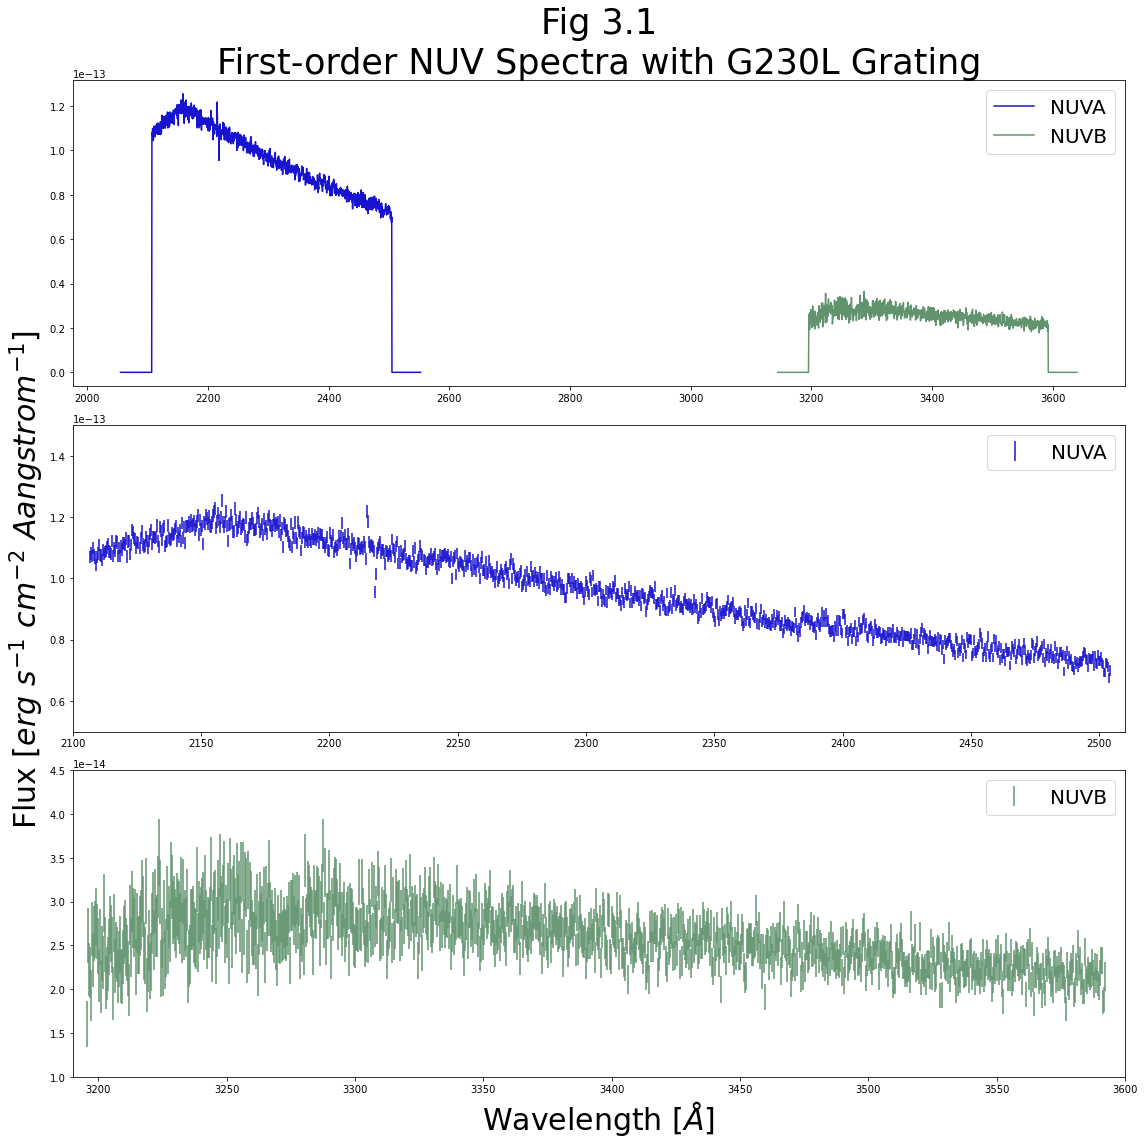

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize = (16, 16))

for i in range(2):
    wvln, flux, fluxErr = x1d_data[i]["WAVELENGTH"], x1d_data[i]["FLUX"], x1d_data[i]["ERROR"]
    segment = x1d_data[i]["SEGMENT"]

    ax0.plot(wvln, flux,
                linestyle = "-", label = segment, c = segment_colors[segment])
    ax0.legend(fontsize = 20 )
    ax0.set_title("Fig 3.1\nFirst-order NUV Spectra with G230L Grating", size = 35)
    
    if i == 0:
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] )
        ax1.set_xlim(2100,2510)
        ax1.set_ylim(0.5E-13,1.5E-13)
        ax1.legend(fontsize = 20 )
        ax1.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 30)
        
    if i == 1:
        ax2.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] )
        ax2.set_xlim(3190,3600)
        ax2.set_ylim(1E-14,4.5E-14)
        ax2.legend(fontsize = 20 )
        ax2.set_xlabel('Wavelength [$\AA$]', size = 30)

plt.tight_layout()
plt.show()

## 3.2. Examining the second-order spectrum

On segment C, we have a more dispersed spectrum over a smaller chunk of the NUV. Below, we plot this portion over the first-order spectrum from segment A.

Clearly, our errorbars on the second-order spectrum are *much larger*. However, if we need a very high dispersion, for instance, to split close-together lines, the lower panel (zoom) shows a potential advantage of segment C. Its higher spectral sampling rate allows for finer distinctions in wavelength.

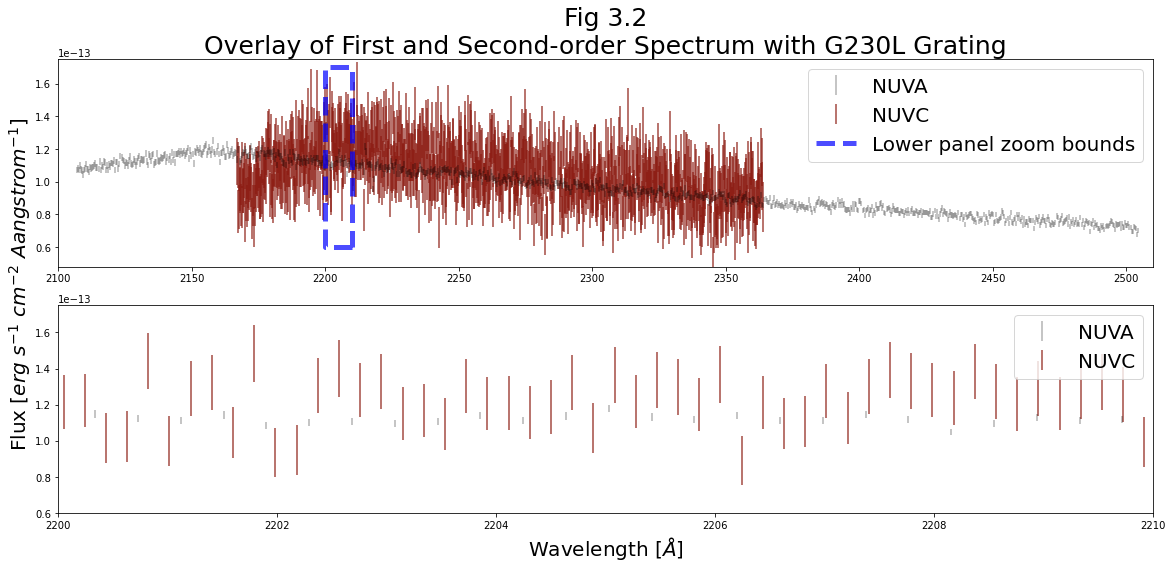

In [16]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize = (16, 8))

for i in [2,0]: #We reverse this order, so that the 0th segment (A) is plotted OVER the 2nd segment (C). It's purely aesthetic
    wvln, flux, fluxErr = x1d_data[i]["WAVELENGTH"], x1d_data[i]["FLUX"], x1d_data[i]["ERROR"]
    segment = x1d_data[i]["SEGMENT"]
    
    if i == 0:
        ax0.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = 'k', alpha = 0.3)
        
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = 'k', alpha = 0.3)
        
    if i == 2:
        ax0.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] , alpha = 0.8)
        
        ax1.errorbar(x = wvln, y = flux, yerr = fluxErr,
                    linestyle = "",  label = segment, c = segment_colors[segment] , alpha = 0.8)

 
ax0.set_xlim(2100,2510)
ax0.set_ylim(0.48E-13,1.75E-13)

ax0.set_title("Fig 3.2\nOverlay of First and Second-order Spectrum with G230L Grating", size = 25)

ax1.set_xlim(2200,2210)
ax1.set_ylim(0.6E-13,1.75E-13)

ax1.set_xlabel('Wavelength [$\AA$]', size = 20)
fig.text(-0.015, 0.5, 'Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 20, va='center', rotation='vertical')       

#Let's add a dashed rectangle to show where we are zooming into in the lower panel.
ax0.plot([2210,2200,2200,2210,2210],[0.6E-13,0.6E-13,1.7E-13,1.7E-13,0.6E-13], 
        'b', linewidth = 5, linestyle = '--', alpha = 0.7, label = "Lower panel zoom bounds")


handles,labels = ax0.get_legend_handles_labels() # These lines just ensure that the legend is ordered correctly (first ax0)
handles = [handles[2], handles[1], handles[0]]
labels = [labels[2], labels[1], labels[0]]
ax0.legend(handles, labels, fontsize = 20 , loc = 'upper right')
handles,labels = ax1.get_legend_handles_labels() # Now for ax1
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
ax1.legend(handles,labels, fontsize = 20 , loc = 'upper right')

plt.tight_layout()
plt.show()

### Exercise 3: *Removing the zeros*

All of the segments have real, useful data, bookended on each size by zeros (see Fig. 3.1, upper panel).

1. Plot a histogram of each section's FLUX to visualize this 
2. Plot segments A and B as in Fig. 3.1, without these zero values

In [17]:
# Your answer here




## 3.3. Reading in and plotting with `specutils`
### *(Optional)*
An alternative way to read in spectral data is with the [`specutils` package](https://specutils.readthedocs.io/en/stable/), which contains quite a bit of functionality for working with spectra. It also can make dealing with units easier, as it works well with astropy units and other modules.

Below is a simple example of using `specutils` to read-in, plot, and continuum-normalize our spectrum.

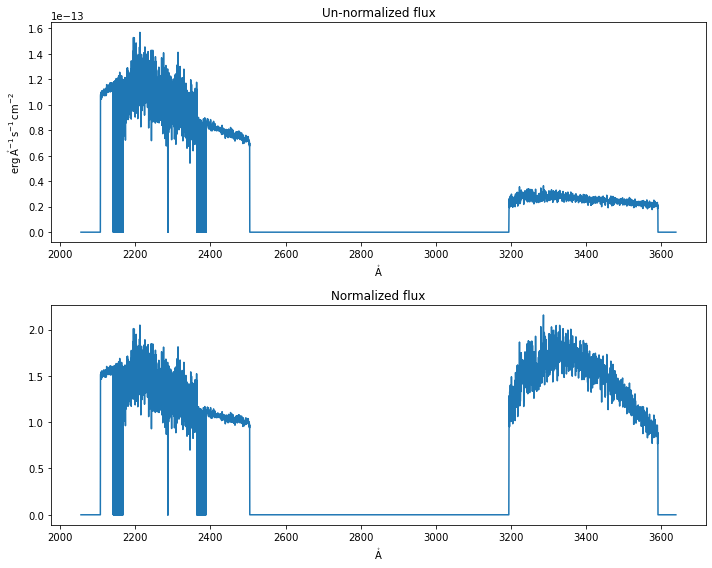

In [18]:
import specutils
from specutils.fitting import fit_generic_continuum
spec1d = specutils.Spectrum1D.read(x1d_filepath)

fig, (ax0,ax1) = plt.subplots(2,1,figsize = (10,8))

#Plot the non-normalized flux
ax0.plot(spec1d.wavelength , spec1d.flux)
ax0.set_title("Un-normalized flux")

# Continuum Normalize the flux:
cont_norm_spec1d = spec1d /fit_generic_continuum(spec1d)(spec1d.spectral_axis) 

#Plot the normalized flux
ax1.plot(cont_norm_spec1d.wavelength , cont_norm_spec1d.flux)
ax1.set_title("Normalized flux")

plt.tight_layout()
plt.show()

## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/nkerman/Walkthroughs)


---
## About this Notebook
**Author:** [Nat Kerman](nkerman@stsci.edu)
**Updated On:** 2020-10-06

>*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*>*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topV)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 



# Any miscellaneous cells/quick hacks/ exercise solutions below:

## Exercise Solutions:

In [19]:
## Ex. 1 soln:
dataset_id_ = 'LDLM40010'
exptime_ = 12403.904*u.s
print(f"The TRAPPIST-1 COS data is in dataset {dataset_id_}, taken with an exosure time of {exptime_}")

The TRAPPIST-1 COS data is in dataset LDLM40010, taken with an exosure time of 12403.904 s


In [20]:
## Ex. 2 soln:
query_3 = Observations.query_criteria(obs_id = 'LDLM40010',
                                        wavelength_region="UV", instrument_name="COS/FUV", filters = 'G130M')

product_list2 = Observations.get_product_list(query_3)
rawRowsA = np.where(product_list2['productSubGroupDescription'] == "RAWTAG_A")
rawRowsB = np.where(product_list2['productSubGroupDescription'] == "RAWTAG_B")
rawRows = np.append(rawRowsA,rawRowsB)

downloads2 = Observations.download_products(product_list2[rawRows], download_dir=datadir+'Ex2/' , extension='fits', mrp_only=False, cache=True)
downloads3 = Observations.download_products(product_list2, download_dir=datadir+'Ex2/' , extension='fits', mrp_only=True, cache=True)

asn_data = Table.read('./data/Ex2/mastDownload/HST/ldlm40010/ldlm40010_asn.fits', hdu = 1)
print(asn_data)

INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40alq/ldlm40alq_rawtag_a.fits with expected size 555840. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40alq/ldlm40alq_rawtag_a.fits with expected size 555840.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40axq/ldlm40axq_rawtag_a.fits with expected size 947520. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40axq/ldlm40axq_rawtag_a.fits with expected size 947520.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40blq/ldlm40blq_rawtag_a.fits with expected size 950400. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40blq/ldlm40blq_rawtag_a.fits with expected size 950400.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40c2q/ldlm40c2q_rawtag_a.fits with expected size 959040. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40c2q/ldlm40c2q_rawtag_a.fits with expected size 959040.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40d2q/ldlm40d2q_rawtag_a.fits with expected size 967680. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40d2q/ldlm40d2q_rawtag_a.fits with expected size 967680.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40alq/ldlm40alq_rawtag_b.fits with expected size 1506240. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40alq/ldlm40alq_rawtag_b.fits with expected size 1506240.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40axq/ldlm40axq_rawtag_b.fits with expected size 6275520. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40axq/ldlm40axq_rawtag_b.fits with expected size 6275520.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40blq/ldlm40blq_rawtag_b.fits with expected size 6301440. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40blq/ldlm40blq_rawtag_b.fits with expected size 6301440.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40c2q/ldlm40c2q_rawtag_b.fits with expected size 6379200. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40c2q/ldlm40c2q_rawtag_b.fits with expected size 6379200.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40d2q/ldlm40d2q_rawtag_b.fits with expected size 6353280. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40d2q/ldlm40d2q_rawtag_b.fits with expected size 6353280.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40010/ldlm40010_asn.fits with expected size 11520. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40010/ldlm40010_asn.fits with expected size 11520.


INFO: Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40010/ldlm40010_x1dsum.fits with expected size 1287360. [astroquery.query]


INFO:astropy:Found cached file /Users/nkerman/Projects/Walkthroughs/ViewData/data/Ex2/mastDownload/HST/ldlm40010/ldlm40010_x1dsum.fits with expected size 1287360.


   MEMNAME        MEMTYPE     MEMPRSNT
-------------- -------------- --------
     LDLM40ALQ         EXP-FP        1
     LDLM40AXQ         EXP-FP        1
     LDLM40BLQ         EXP-FP        1
     LDLM40C2Q         EXP-FP        1
     LDLM40D2Q         EXP-FP        1
     LDLM40010        PROD-FP        1


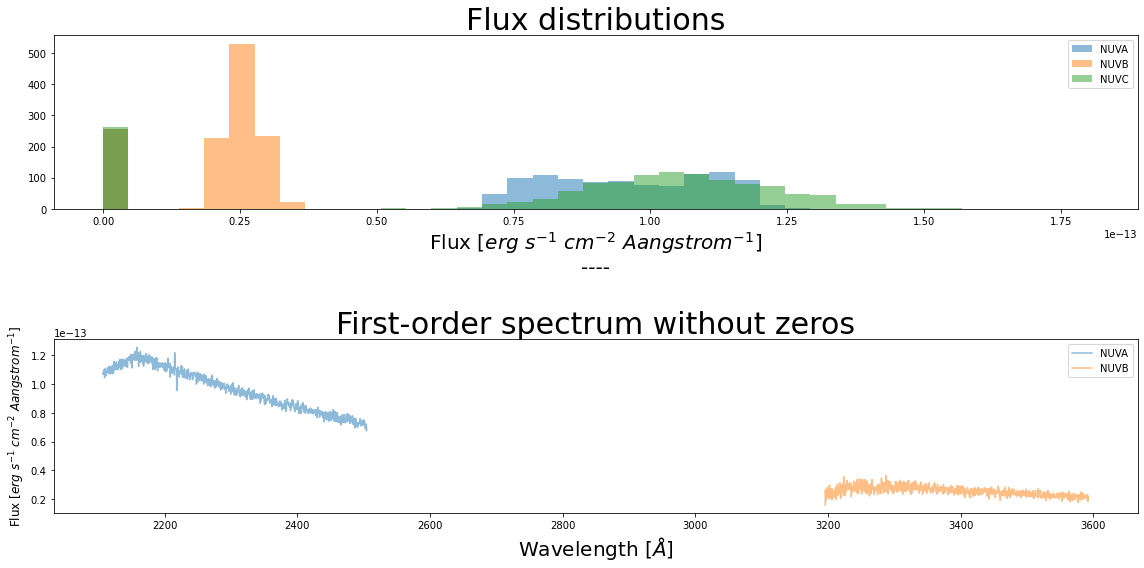

In [21]:
## Ex. 3 Soln:
fig, (ax0,ax1) = plt.subplots(2,1,figsize = (16, 8))

for q in range(3):
    ax0.hist(x1d_data[q]["FLUX"], alpha = 0.5, label = x1d_data[q]["SEGMENT"], bins = np.linspace(0,1.8E-13,40))

for q in range(2):
    mask_no_zeros = (x1d_data[q]["FLUX"] > 0)
    ax1.plot(x1d_data[q]["WAVELENGTH"][mask_no_zeros],x1d_data[q]["FLUX"][mask_no_zeros], alpha = 0.5, label = x1d_data[q]["SEGMENT"])

ax0.legend()
ax0.set_title("Flux distributions", size = 30)

ax1.legend()
ax1.set_title("First-order spectrum without zeros", size = 30)

ax0.set_xlabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]\n----\n', size = 20)
ax1.set_xlabel('Wavelength [$\AA$]', size = 20)
ax1.set_ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ Aangstrom^{-1}$]', size = 12)

plt.tight_layout()

### Misc/Junk

In [22]:
# mask = (query_1['obs_id'] == 'lbbd01020')
mask_prod_list2 = (product_list['obs_id'] == 'lbbd01hpq') | (product_list['obs_id'] == 'lbbd01020' )
product_list[mask_prod_list2]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str3,str8,str9,str62,str1,str44,str9,str28,str9,str1,str6,str5,str5,str27,int64,str10
2003886000,HST,spectrum,lbbd01020,DADS JIF file,C,mast:HST/product/lbbd01020_jif.fits,AUXILIARY,--,JIF,--,CALCOS,--,11896,lbbd01020_jif.fits,34560,2003886000
2003886000,HST,spectrum,lbbd01020,DADS JIT file,C,mast:HST/product/lbbd01020_jit.fits,AUXILIARY,--,JIT,--,CALCOS,--,11896,lbbd01020_jit.fits,57600,2003886000
2003886000,HST,spectrum,lbbd01020,DADS TRL file - Processing log,C,mast:HST/product/lbbd01020_trl.fits,AUXILIARY,--,TRL,--,CALCOS,--,11896,lbbd01020_trl.fits,20160,2003886000
2003886000,HST,spectrum,lbbd01020,DADS X3S file - Summed 1D spectrum COS,C,mast:HST/product/lbbd01020_x1dsum3.fits,AUXILIARY,--,X1DSUM3,--,CALCOS,3.3.9,11896,lbbd01020_x1dsum3.fits,195840,2003886000
2003886000,HST,spectrum,lbbd01020,DADS ASN file - Association ACS/WFC3/STIS,C,mast:HST/product/lbbd01020_asn.fits,AUXILIARY,Minimum Recommended Products,ASN,--,CALCOS,3.3.9,11896,lbbd01020_asn.fits,11520,2003886000
2003886000,HST,spectrum,lbbd01020,DADS XSM file - Calibrated combined extracted 1D spectrum COS,C,mast:HST/product/lbbd01020_x1dsum.fits,SCIENCE,Minimum Recommended Products,X1DSUM,--,CALCOS,3.3.9,11896,lbbd01020_x1dsum.fits,195840,2003886000
2003886000,HST,spectrum,lbbd01020,Preview-Thumb,C,mast:HST/product/lbbd01020_x1dsum_thumb.png,THUMBNAIL,--,--,--,CALCOS,3.3.9,11896,lbbd01020_x1dsum_thumb.png,5881,2003886000
2003886000,HST,spectrum,lbbd01020,Preview-Thumb,C,mast:HST/product/lbbd01020_x1dsum3_thumb.png,THUMBNAIL,--,--,--,CALCOS,3.3.9,11896,lbbd01020_x1dsum3_thumb.png,5881,2003886000
2003183208,HST,spectrum,lbbd01hpq,DADS CTG file - Corrected events COS,S,mast:HST/product/lbbd01hpq_corrtag.fits,AUXILIARY,--,CORRTAG,--,CALCOS,3.3.9,11896,lbbd01hpq_corrtag.fits,142035840,2003886000
